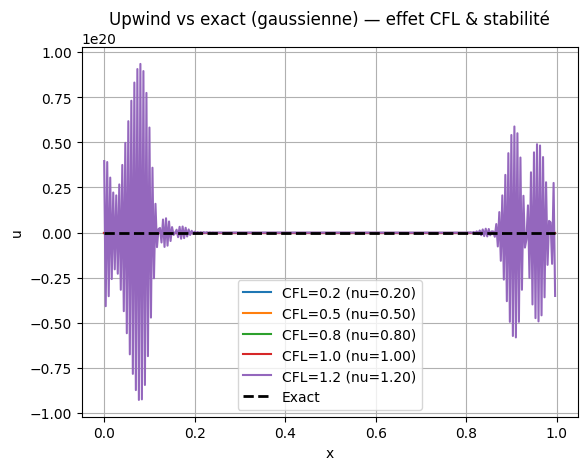

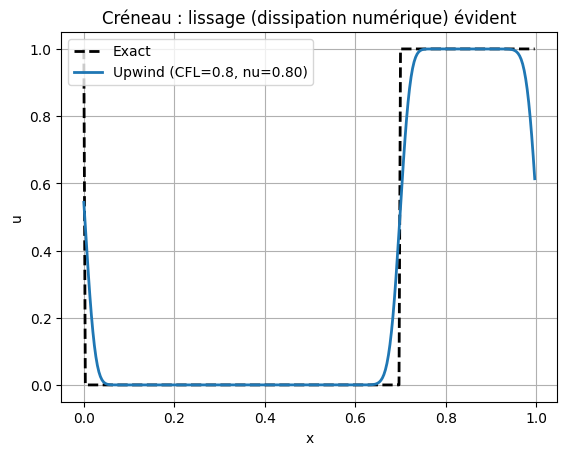

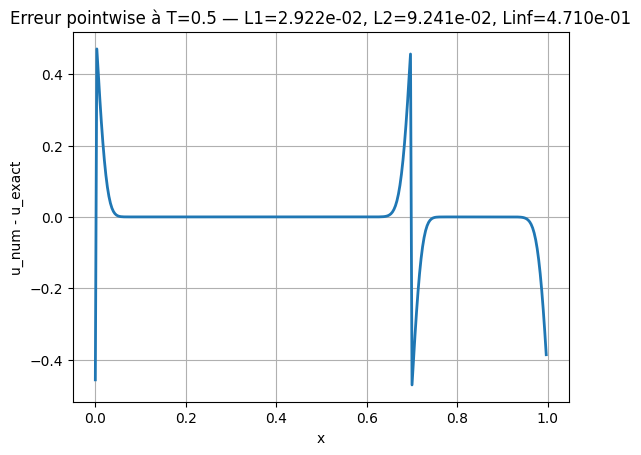

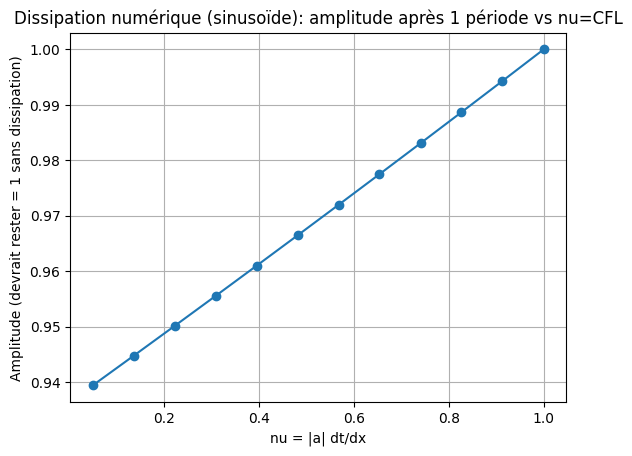

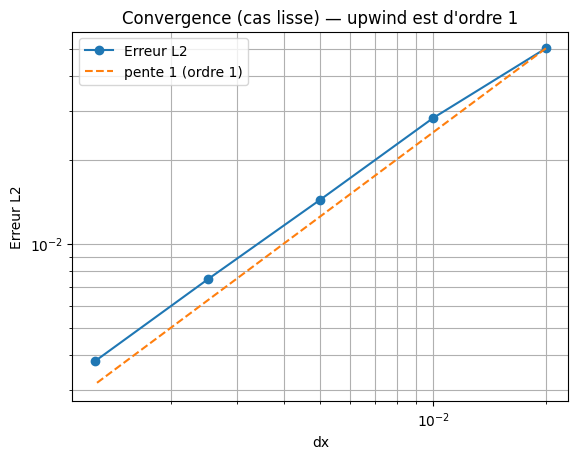

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Initial conditions
# -----------------------------
def u0_sine(x):
    return np.sin(2*np.pi*x)

def u0_gaussian(x, x0=0.3, sigma=0.05):
    # périodique: on prend la distance minimale modulo 1
    d = np.minimum(np.abs(x-x0), 1.0-np.abs(x-x0))   #Car 0.02 (par exemple)est tres proche de 1 grace a la périodicité
    return np.exp(-(d**2)/(2*sigma**2))

def u0_square(x, xL=0.2, xR=0.5):
    # créneau périodique
    return ((x >= xL) & (x <= xR)).astype(float)

# -----------------------------
# Exact solution (periodic)
# -----------------------------
def exact_solution(x, t, a, u0_func):
    # wrap in [0,1)
    xshift = (x - a*t) % 1.0
    return u0_func(xshift)

# -----------------------------
# One upwind step (periodic BC)
# -----------------------------
def upwind_step(u, a, dt, dx):
    nu = a * dt / dx
    if a >= 0:
        # u^{n+1}_j = u^n_j - nu (u^n_j - u^n_{j-1})
        return u - nu * (u - np.roll(u, 1))
    else:
        # u^{n+1}_j = u^n_j - nu (u^n_{j+1} - u^n_j)  (nu<0)
        return u - nu * (np.roll(u, -1) - u)

# -----------------------------
# Norms for error
# -----------------------------
def error_norms(u_num, u_ex):
    e = u_num - u_ex
    L1 = np.mean(np.abs(e))
    L2 = np.sqrt(np.mean(e**2))
    Linf = np.max(np.abs(e))
    return L1, L2, Linf

# -----------------------------
# Run a simulation
# -----------------------------
def run_simulation(a=1.0, nx=200, CFL=0.8, T=1.0, u0_func=u0_sine, snapshots=5):
    x = np.linspace(0, 1.0, nx, endpoint=False)
    dx = x[1] - x[0]
    dt = CFL * dx / abs(a) if a != 0 else 1e-3
    nt = int(np.ceil(T / dt))
    dt = T / nt  # ajuste pour tomber exactement sur T
    nu = abs(a) * dt / dx

    u = u0_func(x).copy()

    # moments où on sauvegarde
    snap_times = np.linspace(0, T, snapshots)
    snap_idx = set((snap_times / dt).round().astype(int).tolist())
    #But : tu veux sauvegarder par exemple 5 images à des temps uniforme
    #.round() : prend le pas le plus proche.
    #set(...) : pour éviter les doublons.
    #
    history = []
    for n in range(nt + 1):
        t = n * dt
        if n in snap_idx:
            u_ex = exact_solution(x, t, a, u0_func)
            history.append((t, u.copy(), u_ex))
            #Parce que u va changer à chaque itération.
            #Si tu stockes juste u, tu risques de stocker une référence qui se fait écraser. Le .copy() fige l’état.
        if n < nt:
            u = upwind_step(u, a, dt, dx)

    # erreur finale
    u_ex_T = exact_solution(x, T, a, u0_func)
    norms = error_norms(u, u_ex_T)

    return x, u, u_ex_T, (dt, dx, nt, nu), norms, history

# -----------------------------
# Dissipation test on sine: amplitude decay
# -----------------------------
def sine_amplitude(u, x):
    # projection sur sin(2πx) et cos(2πx) -> amplitude
    s = np.sin(2*np.pi*x)
    c = np.cos(2*np.pi*x)
    a_s = 2*np.mean(u*s)
    a_c = 2*np.mean(u*c)
    return np.sqrt(a_s**2 + a_c**2)

# -----------------------------
# Main demo
# -----------------------------
if __name__ == "__main__":
    a = 1.0
    nx = 300
    T = 1.0  # 1 période si a=1 sur [0,1) (retour à l’état initial)
    CFL_list = [0.2, 0.5, 0.8, 1.0, 1.2]  # 1.2 -> instable attendu

    # 1) Test stabilité CFL
    plt.figure()
    for CFL in CFL_list:
        try:
            x, uT, uexT, meta, norms, _ = run_simulation(a=a, nx=nx, CFL=CFL, T=T, u0_func=u0_gaussian)
            dt, dx, nt, nu = meta
            L1, L2, Linf = norms
            plt.plot(x, uT, label=f"CFL={CFL:.1f} (nu={nu:.2f})")
        except Exception as e:
            print("Erreur pour CFL=", CFL, e)

    plt.plot(x, exact_solution(x, T, a, u0_gaussian), "k--", lw=2, label="Exact")
    plt.title("Upwind vs exact (gaussienne) — effet CFL & stabilité")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Comparaison upwind vs exact + erreur (cas créneau: dissipation visible)
    CFL = 0.8
    x, uT, uexT, meta, norms, history = run_simulation(a=a, nx=nx, CFL=CFL, T=0.5, u0_func=u0_square, snapshots=4)
    dt, dx, nt, nu = meta
    L1, L2, Linf = norms

    plt.figure()
    plt.plot(x, uexT, "k--", lw=2, label="Exact")
    plt.plot(x, uT, lw=2, label=f"Upwind (CFL={CFL}, nu={nu:.2f})")
    plt.title("Créneau : lissage (dissipation numérique) évident")
    plt.xlabel("x")
    plt.ylabel("u")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    err = uT - uexT
    plt.plot(x, err, lw=2)
    plt.title(f"Erreur pointwise à T=0.5 — L1={L1:.3e}, L2={L2:.3e}, Linf={Linf:.3e}")
    plt.xlabel("x")
    plt.ylabel("u_num - u_exact")
    plt.grid(True)
    plt.show()

    # 3) Étude dissipation sur une sinusoïde: amplitude après une période
    CFL_grid = np.linspace(0.05, 1.0, 12)
    amps = []
    nus = []
    for CFL in CFL_grid:
        x, uT, uexT, meta, norms, _ = run_simulation(a=a, nx=nx, CFL=CFL, T=T, u0_func=u0_sine)
        dt, dx, nt, nu = meta
        A = sine_amplitude(uT, x)
        amps.append(A)
        nus.append(nu)

    plt.figure()
    plt.plot(nus, amps, "-o")
    plt.title("Dissipation numérique (sinusoïde): amplitude après 1 période vs nu=CFL")
    plt.xlabel("nu = |a| dt/dx")
    plt.ylabel("Amplitude (devrait rester = 1 sans dissipation)")
    plt.grid(True)
    plt.show()

    # 4) Convergence en espace (ordre 1 attendu) sur cas lisse
    CFL = 0.8
    nx_list = [50, 100, 200, 400, 800]
    dxs = []
    L2s = []
    for nx_i in nx_list:
        x, uT, uexT, meta, norms, _ = run_simulation(a=a, nx=nx_i, CFL=CFL, T=0.3, u0_func=u0_gaussian)
        dt, dx, nt, nu = meta
        L1, L2, Linf = norms
        dxs.append(dx)
        L2s.append(L2)

    plt.figure()
    plt.loglog(dxs, L2s, "-o", label="Erreur L2")
    # guide slope ~1
    plt.loglog(dxs, L2s[0]*(np.array(dxs)/dxs[0])**1, "--", label="pente 1 (ordre 1)")
    plt.title("Convergence (cas lisse) — upwind est d'ordre 1")
    plt.xlabel("dx")
    plt.ylabel("Erreur L2")
    plt.legend()
    plt.grid(True, which="both")
    plt.show()


